In [1]:
import sys
sys.path.append('/mnt/d/ariel2/code/core/')
sys.path.append('d:/ariel2/code/core/')
sys.path.append('/kaggle/input/my-ariel2-library')
import kaggle_support as kgs
import ariel_model
import ariel_numerics
import ariel_gp
import ariel_load
import ariel_load_FGS
import time
import numpy as np
import multiprocess
import importlib
import copy
import cupy as cp
import matplotlib.pyplot as plt
from tqdm import tqdm
importlib.reload(ariel_load)

local


<module 'ariel_load' from '/mnt/d/ariel2/code/core/ariel_load.py'>

In [2]:
train_data = kgs.load_all_train_data()
kgs.debugging_mode = 2

0
0.7166641123639067
-3.7118804446985987
-4.014785848984063


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

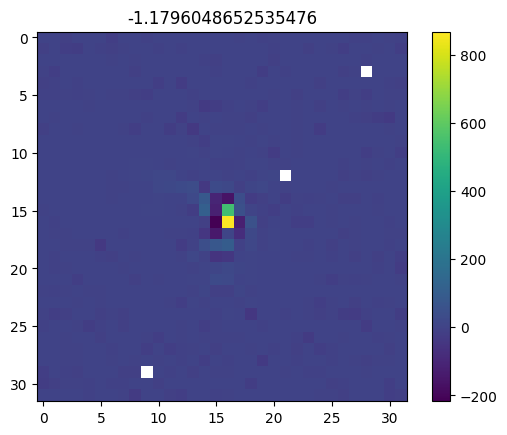

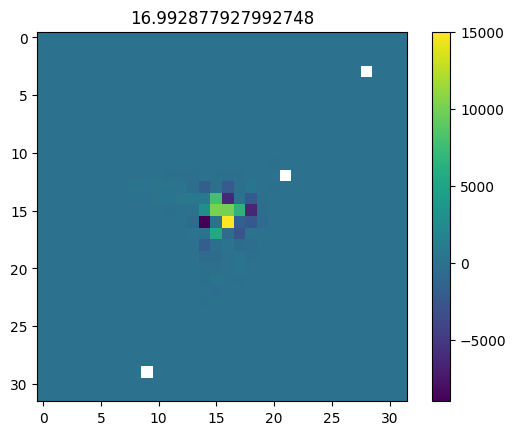

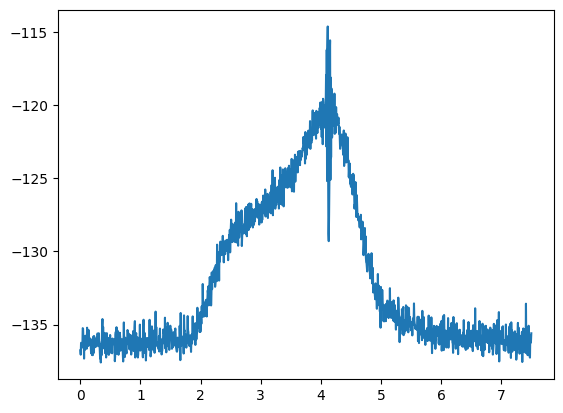

min 0.0 0.0
-3.7118804446985987
-4.014785848984063


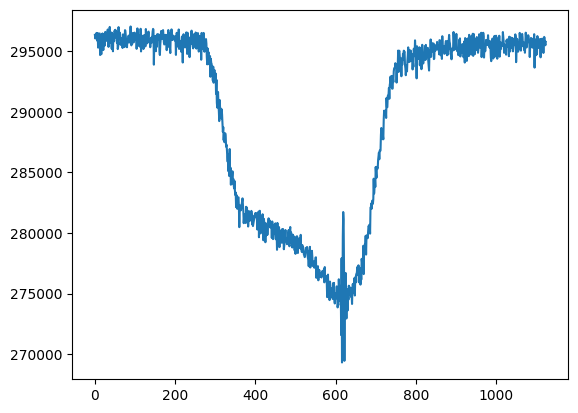

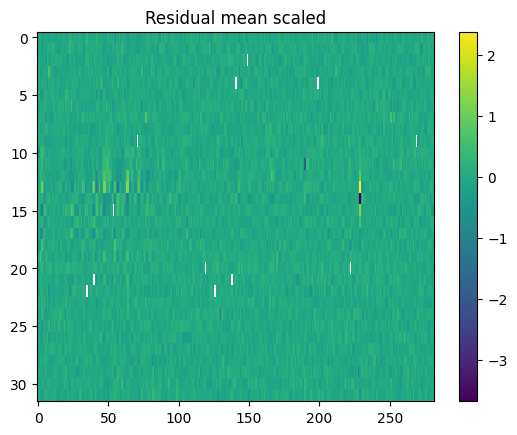

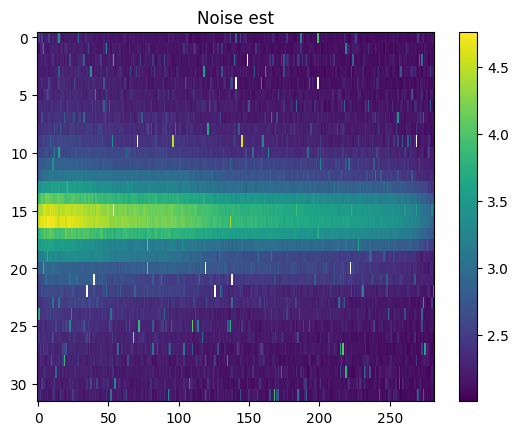

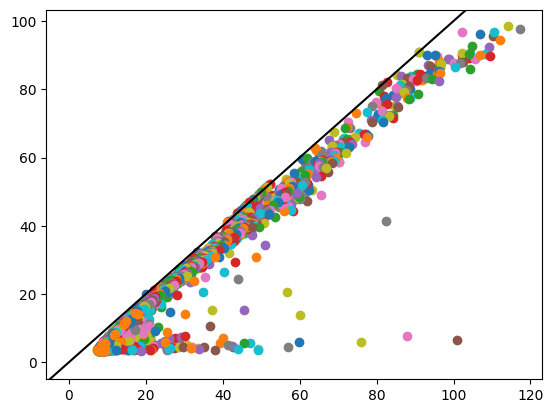

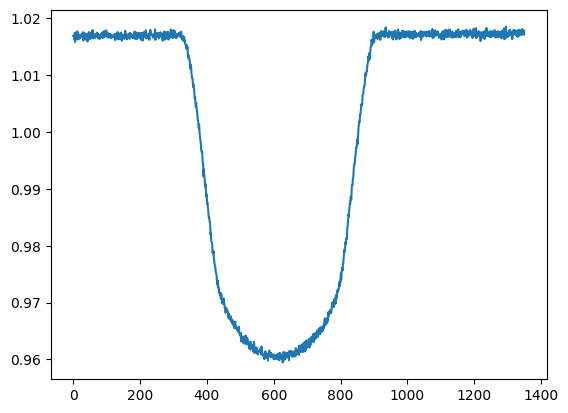

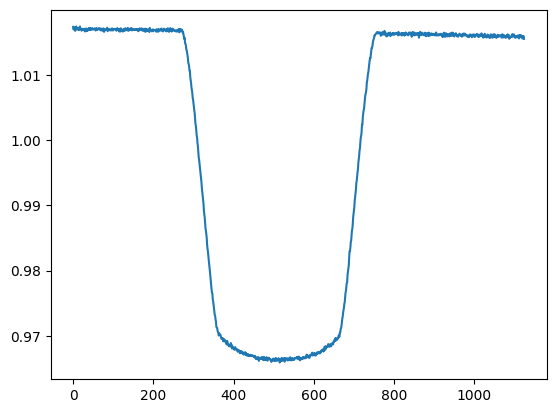

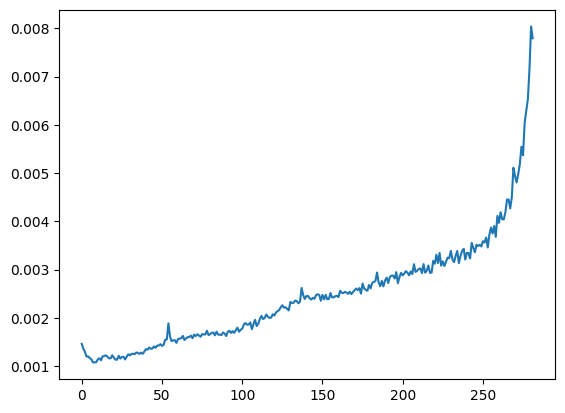

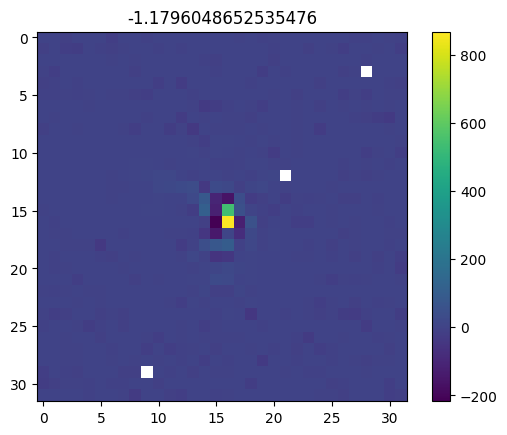

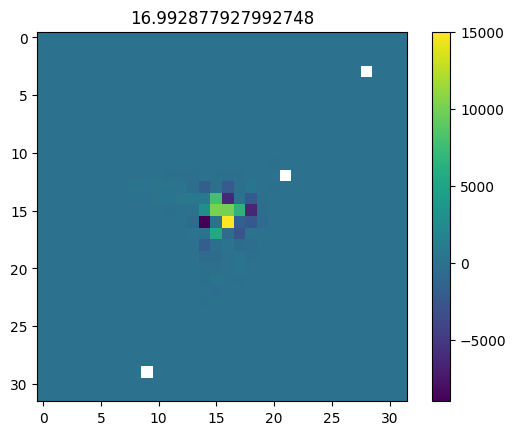

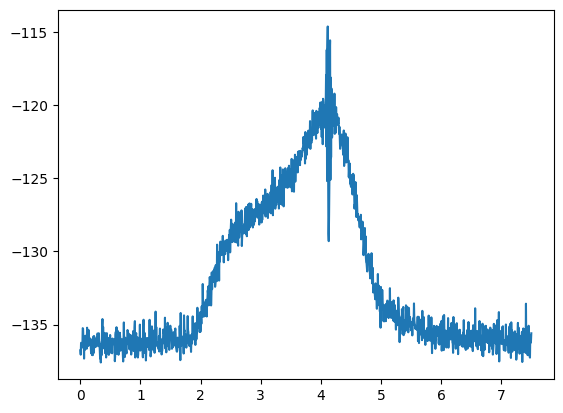

min 0.0 0.0


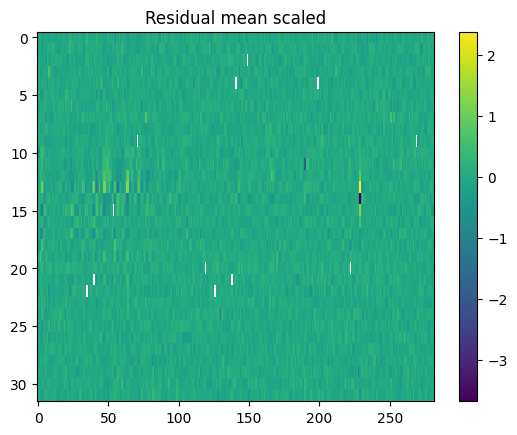

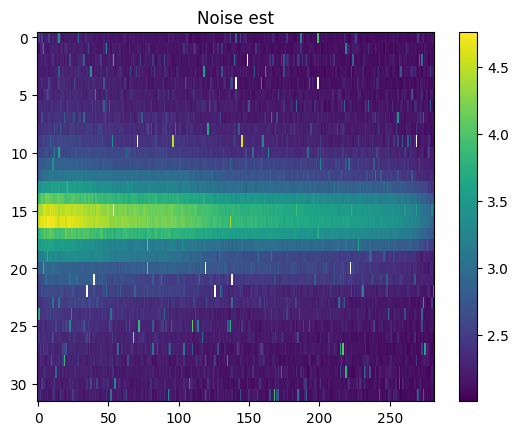

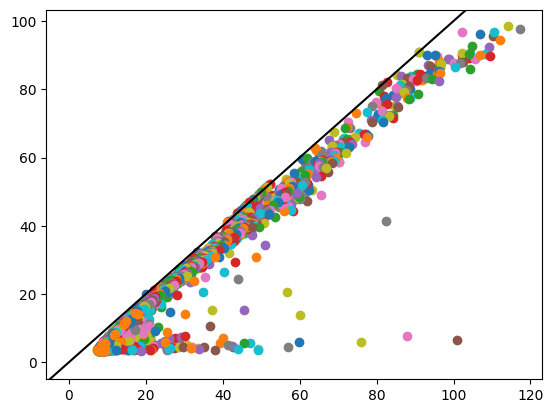

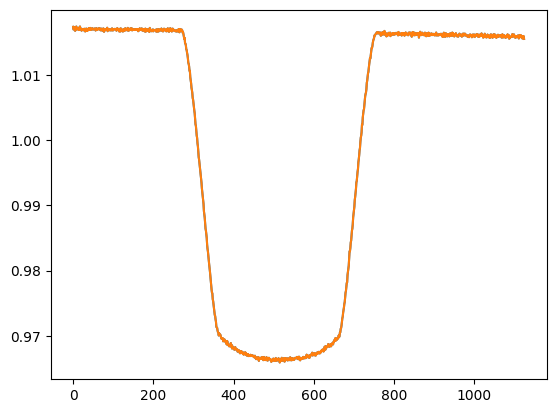

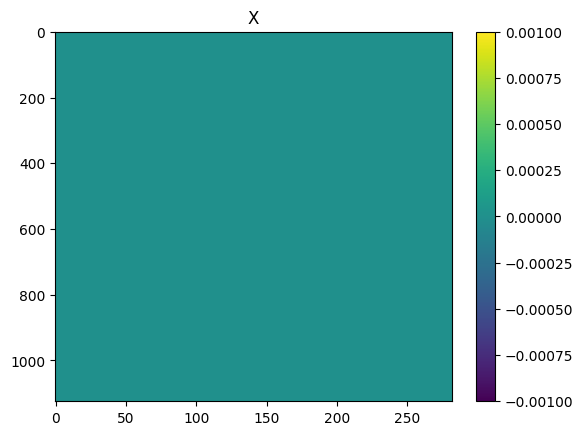

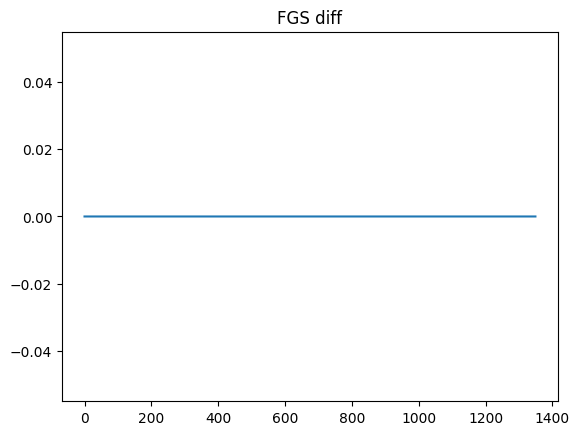

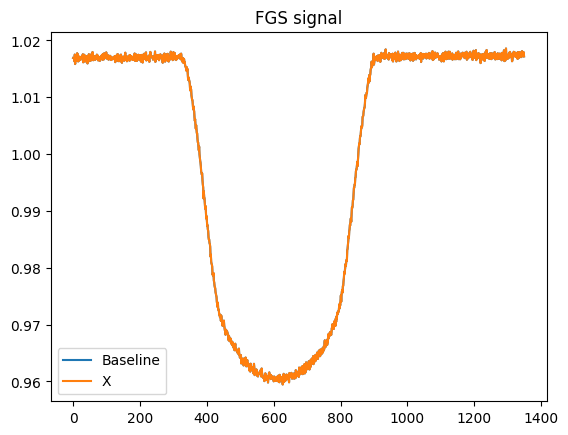

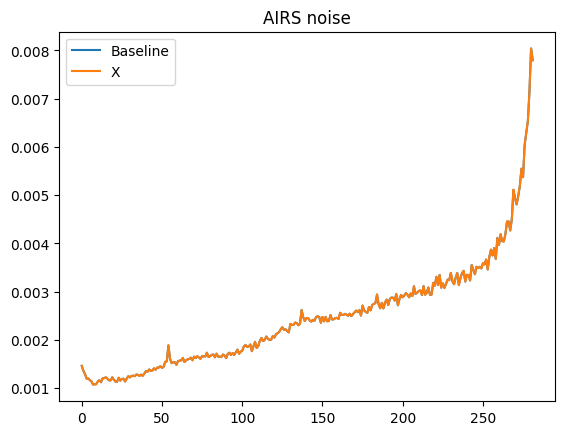

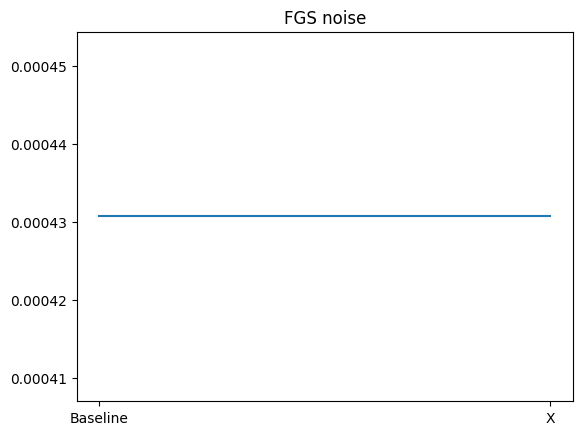

In [3]:
importlib.reload(ariel_load)
loader_list = []
names = []

kgs.sanity_checks_active = False

hole_poke = False

loaders = ariel_load.default_loaders()
loaders[0].cache_steps = [4]
loader_list.append(copy.deepcopy(loaders))
names.append('Baseline')

if hole_poke:
    loaders = ariel_load.default_loaders()
    for ii in range(2):
        loaders[ii].apply_pixel_corrections.poke_holes = True
    loader_list.append(copy.deepcopy(loaders))
    names.append('Introduce hole')

# for ii in range(2):
#     loaders[ii].apply_full_sensor_corrections.remove_background_remove_used_rows = False   
# loader_list.append(copy.deepcopy(loaders))
# names.append('Baseline with bad rows')

# loaders[0].apply_wavelength_binning = ariel_load_FGS.ApplyWavelengthBinningFGS2()
# loaders[0].apply_wavelength_binning.n_mean_pixels = 0
# loaders[0].apply_pixel_corrections.mask_hot = False
# loaders[0].apply_full_sensor_corrections.inpainting_2d = True
# loaders[0].apply_full_sensor_corrections.restore_invalids = True
# loaders[0].apply_full_sensor_corrections.remove_background_based_on_pixels = True
# loader_list.append(copy.deepcopy(loaders))
# names.append('New FGS')

# loaders[0].apply_wavelength_binning.options.use_sum = True
# loader_list.append(copy.deepcopy(loaders))
# names.append('FGS sum')

loader_list.append(copy.deepcopy(loaders))
names.append('X')

# loaders[1].apply_full_sensor_corrections.inpainting_wavelength = False
# loaders[1].apply_pixel_corrections.mask_hot = False
# loaders[1].apply_full_sensor_corrections.use_pca_for_background_removal = False
# loaders[1].apply_full_sensor_corrections.remove_background_based_on_rows = False
# loaders[1].apply_full_sensor_corrections.remove_background_remove_used_rows = False
# loaders[1].apply_wavelength_binning = ariel_load.ApplyWavelengthBinningAIRS2()
# loaders[1].apply_wavelength_binning.make_diagnostic_plots = False
# loaders[1].apply_wavelength_binning.residual_threshold = 100
# loaders[1].apply_wavelength_binning.use_noise_est_naive = True
# #loader_list.append(copy.deepcopy(loaders))
# #names.append('New AIRS naive')

# loaders[1].apply_full_sensor_corrections.inpainting_wavelength = False
# loaders[1].apply_pixel_corrections.mask_hot = False
# loaders[1].apply_full_sensor_corrections.use_pca_for_background_removal = False
# loaders[1].apply_full_sensor_corrections.remove_background_based_on_rows = False
# loaders[1].apply_full_sensor_corrections.remove_background_remove_used_rows = False
# loaders[1].apply_wavelength_binning = ariel_load.ApplyWavelengthBinningAIRS2()
# loaders[1].apply_wavelength_binning.make_diagnostic_plots = False
# loaders[1].apply_wavelength_binning.residual_threshold = 100
# loaders[1].apply_wavelength_binning.sequential_fit = True
#loader_list.append(copy.deepcopy(loaders))
#names.append('New AIRS sequential')

# loaders[1].apply_pixel_corrections.mask_hot = True
# loader_list.append(copy.deepcopy(loaders))
# names.append('New AIRS mask hot')


#loader_list.append(copy.deepcopy(loaders))
#names.append('New AIRS threshold 30 no mask hot')

# for ii in range(2):
#     loaders[ii].apply_full_sensor_corrections.remove_background_remove_used_rows = False
#     loaders[ii].apply_wavelength_binning = ariel_load.ApplyWavelengthBinning2()
# loaders[0].apply_wavelength_binning.options.n_components = 4
# loaders[1].apply_wavelength_binning.options.n_components = 3
# loader_list.append(copy.deepcopy(loaders))
# names.append('New with inpainting')

# for ii in range(2):
#     loaders[ii].apply_full_sensor_corrections.inpainting_2d = False
#     loaders[ii].apply_full_sensor_corrections.inpainting_wavelength = False
# loader_list.append(copy.deepcopy(loaders))
# names.append('New w/o inpainting')

# loaders[1].apply_wavelength_binning.options.n_components = 1
# loader_list.append(copy.deepcopy(loaders))
# names.append('New w/o inpainting 1 comp')

model = ariel_gp.PredictionModel()
model.plot_final = True
model.train(train_data)

ariel_load_FGS.diagnostic_plots = True
ariel_load.diagnostic_plots = True

kgs.profiling=False
for ii,d in enumerate(train_data[2:3]):
    print(ii)
    d=copy.deepcopy(d)
    fig_fgs_noise = plt.figure()
    fig_fgs_sig = plt.figure()    
    fig_airs_noise = plt.figure()
    fig_airs_sig=  plt.figure()
    fgs_noise_vals = []
    for j,load in enumerate(loader_list):
        d.load_to_step(0,load)
        d.load_to_step(5,load)
        
        fgs_sig = copy.deepcopy(d.transits[0].data[0].data)
        fgs_sig = fgs_sig/kgs.rms(fgs_sig)
        fgs_noise_vals.append(ariel_numerics.estimate_noise_cp(fgs_sig).get())
        plt.figure(fig_fgs_sig)
        plt.plot(fgs_sig.get())
        
        airs_sig = copy.deepcopy(d.transits[0].data[1].data)
        for ii in range(airs_sig.shape[1]):
            airs_sig[:,ii]/=kgs.rms(airs_sig[:,ii])
        plt.figure(fig_airs_sig)
        plt.plot(cp.mean(airs_sig,1).get())            
        plt.figure(fig_airs_noise)
        plt.plot(ariel_numerics.estimate_noise_cp(airs_sig).get())
        
        if j==0:
            baseline_airs = airs_sig
            baseline_fgs = fgs_sig
        else:
            plt.figure()
            plt.imshow((airs_sig-baseline_airs).get(), aspect='auto', interpolation = 'none')
            plt.title(names[j])
            plt.colorbar()
            plt.clim([-1e-3,1e-3])
            plt.figure()
            plt.plot((fgs_sig-baseline_fgs).get())
            plt.title('FGS diff')
            
        #model.infer([d])
        
        d.load_to_step(0,load)
    plt.figure(fig_fgs_sig)
    plt.legend(names)
    plt.title('FGS signal')
    plt.figure(fig_airs_noise)
    plt.legend(names)
    plt.title('AIRS noise')
    plt.figure(fig_fgs_noise)
    plt.title('FGS noise')
    plt.plot(fgs_noise_vals)
    plt.xticks(np.arange(len(names)), names)
    #plt.xticks(names)
    plt.pause(0.001)
    #print(d.diagnostics['AIRS_fallback'])

In [ ]:
# residual = load[1].apply_wavelength_binning.residual
# import ariel_diagnostics
# R = cp.clip(residual, -100,100)
# ariel_diagnostics.animate_3d_matrix(R[400:800,...].get())

In [17]:
%debug

> /mnt/d/ariel2/code/analysis/prep/cupy/_core/_kernel.pyx(145)cupy._core._kernel._preprocess_arg()



ipdb>  u


> /mnt/d/ariel2/code/analysis/prep/cupy/_core/_kernel.pyx(159)cupy._core._kernel._preprocess_args()



ipdb>  u


> /mnt/d/ariel2/code/analysis/prep/cupy/_core/_kernel.pyx(1285)cupy._core._kernel.ufunc.__call__()



ipdb>  u


> /mnt/d/ariel2/code/analysis/prep/cupy/_core/core.pyx(1746)cupy._core.core._ndarray_base.__array_ufunc__()



ipdb>  u


> /mnt/d/ariel2/code/core/ariel_load.py(656)__call__()
    654             noise_est_naive[:,i_wavelength] = 0.4*cp.sqrt(64+cp.abs(cp.mean(dataa[:,:,i_wavelength],0)))
    655             noise_est2 = coeffs[3:]
--> 656             to_change = noise_est2<noise_est_naive[:,i_wavelength]**2
    657             noise_est2[to_change] = (noise_est_naive[:,i_wavelength]**2)[to_change]
    658             noise_est = cp.sqrt(noise_est2)



ipdb>  noise_est2


array([  89.43800616, 1818.71298859,   79.74693902,   78.13094529,
         81.53264444,   90.23161144,   91.79648716,   93.90910483,
        138.12070672,  169.49078519,  151.41907237,  203.16603691,
        325.8104595 ,  786.91223876, 2244.93007405, 6401.00048268,
       7089.35718873, 2085.62937752,  938.2565585 ,  537.25045429,
        265.61170861,  174.9158646 ,  157.6843496 ,  106.59342841,
        115.28996204,   91.96187927,  181.65752031,   79.62668723,
        100.59442714,   71.62789049,   78.90867337,   74.62691392])


ipdb>  type(noise_est2)


<class 'numpy.ndarray'>


ipdb>  type(coffs)


*** NameError: name 'coffs' is not defined


ipdb>  type(coeffs)


<class 'numpy.ndarray'>


ipdb>  q
